In [1]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.tree import DecisionTreeRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import seaborn as sns
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import xgboost as xgb
from sklearn.decomposition import PCA

In [2]:
df = pd.read_csv("Insurance claims data.csv")
df.head()

,policy_id,subscription_length,vehicle_age,customer_age,region_code,region_density,segment,model,fuel_type,max_torque,...,is_brake_assist,is_power_door_locks,is_central_locking,is_power_steering,is_driver_seat_height_adjustable,is_day_night_rear_view_mirror,is_ecw,is_speed_alert,ncap_rating,claim_status
0,POL045360,9.3,1.2,41,C8,8794,C2,M4,Diesel,250Nm@2750rpm,...,Yes,Yes,Yes,Yes,Yes,No,Yes,Yes,3,0
1,POL016745,8.2,1.8,35,C2,27003,C1,M9,Diesel,200Nm@1750rpm,...,No,Yes,Yes,Yes,Yes,Yes,Yes,Yes,4,0
2,POL007194,9.5,0.2,44,C8,8794,C2,M4,Diesel,250Nm@2750rpm,...,Yes,Yes,Yes,Yes,Yes,No,Yes,Yes,3,0
3,POL018146,5.2,0.4,44,C10,73430,A,M1,CNG,60Nm@3500rpm,...,No,No,No,Yes,No,No,No,Yes,0,0
4,POL049011,10.1,1.0,56,C13,5410,B2,M5,Diesel,200Nm@3000rpm,...,No,Yes,Yes,Yes,No,No,Yes,Yes,5,0


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 58592 entries, 0 to 58591
Data columns (total 41 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   policy_id                         58592 non-null  object 
 1   subscription_length               58592 non-null  float64
 2   vehicle_age                       58592 non-null  float64
 3   customer_age                      58592 non-null  int64  
 4   region_code                       58592 non-null  object 
 5   region_density                    58592 non-null  int64  
 6   segment                           58592 non-null  object 
 7   model                             58592 non-null  object 
 8   fuel_type                         58592 non-null  object 
 9   max_torque                        58592 non-null  object 
 10  max_power                         58592 non-null  object 
 11  engine_type                       58592 non-null  object 
 12  airb

In [4]:
df.isna().any()

policy_id                           False
subscription_length                 False
vehicle_age                         False
customer_age                        False
region_code                         False
region_density                      False
segment                             False
model                               False
fuel_type                           False
max_torque                          False
max_power                           False
engine_type                         False
airbags                             False
is_esc                              False
is_adjustable_steering              False
is_tpms                             False
is_parking_sensors                  False
is_parking_camera                   False
rear_brakes_type                    False
displacement                        False
cylinder                            False
transmission_type                   False
steering_type                       False
turning_radius                    

In [5]:
df.describe()

,subscription_length,vehicle_age,customer_age,region_density,airbags,displacement,cylinder,turning_radius,length,width,gross_weight,ncap_rating,claim_status
count,58592.000000,58592.000000,58592.000000,58592.000000,58592.000000,58592.000000,58592.000000,58592.000000,58592.000000,58592.000000,58592.000000,58592.000000,58592.000000
mean,6.111688,1.388473,44.823935,18826.858667,3.137066,1162.355851,3.626963,4.852893,3850.476891,1672.233667,1385.276813,1.759950,0.063968
std,4.142790,1.134413,6.935604,17660.174792,1.832641,266.304786,0.483616,0.228061,311.457119,112.089135,212.423085,1.389576,0.244698
min,0.000000,0.000000,35.000000,290.000000,1.000000,796.000000,3.000000,4.500000,3445.000000,1475.000000,1051.000000,0.000000,0.000000
25%,2.100000,0.400000,39.000000,6112.000000,2.000000,796.000000,3.000000,4.600000,3445.000000,1515.000000,1185.000000,0.000000,0.000000
50%,5.700000,1.200000,44.000000,8794.000000,2.000000,1197.000000,4.000000,4.800000,3845.000000,1735.000000,1335.000000,2.000000,0.000000
75%,10.400000,2.200000,49.000000,27003.000000,6.000000,1493.000000,4.000000,5.000000,3995.000000,1755.000000,1510.000000,3.000000,0.000000
max,14.000000,20.000000,75.000000,73430.000000,6.000000,1498.000000,4.000000,5.200000,4300.000000,1811.000000,1720.000000,5.000000,1.000000


In [6]:
df["claim_status"].value_counts(normalize=True)

0    0.936032
1    0.063968
Name: claim_status, dtype: float64

<AxesSubplot:>

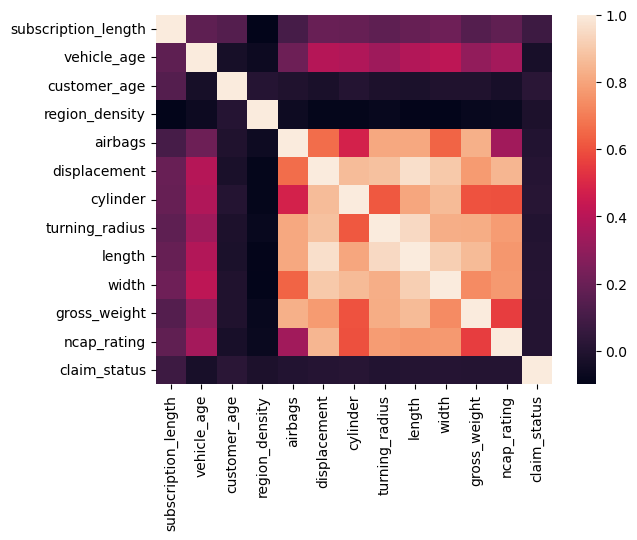

In [7]:
sns.heatmap(df.corr())

This dataset is severely imbalanced. To handle this, we will use weighted xgboost for multi-class classification

In [8]:
#split that dataset

X = df.drop(columns = 'claim_status', axis = 1)
y = df['claim_status']

In [9]:
#split for training and testing

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [10]:
#identify numeric and categorical features for transformations later on in the pipeline

numeric_features = X_train.select_dtypes(include = ["float64", "int64"]).columns.to_list()
categorical_features = X_train.select_dtypes(include = ["object","category"]).columns.to_list()

# Scale the numeric features
numeric_transformer = Pipeline(steps=[('scaler', StandardScaler())])

# One-hot encode the categoricals 
categorical_transformer = Pipeline(steps=[('onehot', OneHotEncoder(handle_unknown='ignore'))])

# XGB Classifier

In [11]:
class_weights = {0:1, 1:10}

# Calculate scale_pos_weight for binary classification
pos_weight = class_weights[1] / class_weights[0]

In [12]:
model = xgb.XGBClassifier(scale_pos_weight=pos_weight)

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ]
)

pipeline = Pipeline([
    ('preprocessor', preprocessor), 
    ('model', model)
])

param_grid = {
    'model__max_depth': [2, 3, 5, 7, 10],
    'model__n_estimators': [10, 100, 500],
}

grid = GridSearchCV(pipeline, param_grid, cv=5, n_jobs=-1, scoring='roc_auc')

In [13]:
grid.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('scaler',
                                                                                          StandardScaler())]),
                                                                         ['subscription_length',
                                                                          'vehicle_age',
                                                                          'customer_age',
                                                                          'region_density',
                                                                          'airbags',
                                                                          'displacement',
                                                                          'cylinder',
     

In [14]:
y_pred = grid.predict(X_test)

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.95      0.83      0.88     10969
           1       0.11      0.33      0.17       750

    accuracy                           0.79     11719
   macro avg       0.53      0.58      0.53     11719
weighted avg       0.89      0.79      0.84     11719



In [15]:
from sklearn.metrics import roc_auc_score
auc = roc_auc_score(y_test, y_pred)
auc

0.5767712036952624

# Balanced Random Forest Classifier

In [16]:
pip install imbalanced-learn

Note: you may need to restart the kernel to use updated packages.


In [17]:
from imblearn.ensemble import BalancedRandomForestClassifier

In [18]:
model_1 = BalancedRandomForestClassifier(n_estimators=100, random_state=42)

pipeline_1 = Pipeline([
    ('preprocessor', preprocessor), 
    ('model', model_1)
])

param_grid_1 = {
    'model__n_estimators': [10, 100, 500],
    'model__bootstrap': [True, False],
    'model__min_samples_split': [2, 5, 10]
}

grid_1 = GridSearchCV(pipeline_1, param_grid_1, cv=5, n_jobs=-1, scoring='roc_auc')

In [19]:
grid_1.fit(X_train, y_train)

/Users/dawsontam/miniforge3/envs/dsc80/lib/python3.8/site-packages/imblearn/ensemble/_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Users/dawsontam/miniforge3/envs/dsc80/lib/python3.8/site-packages/imblearn/ensemble/_forest.py:589: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(
/Users/dawsontam/miniforge3/envs/dsc80/lib/python3.8/site-packages/imblearn/ensemble/_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'al

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('scaler',
                                                                                          StandardScaler())]),
                                                                         ['subscription_length',
                                                                          'vehicle_age',
                                                                          'customer_age',
                                                                          'region_density',
                                                                          'airbags',
                                                                          'displacement',
                                                                          'cylinder',
     

In [20]:
y_pred_1 = grid_1.predict(X_test)

print(classification_report(y_test, y_pred_1))

              precision    recall  f1-score   support

           0       0.96      0.55      0.70     10969
           1       0.10      0.70      0.17       750

    accuracy                           0.56     11719
   macro avg       0.53      0.63      0.44     11719
weighted avg       0.91      0.56      0.67     11719



In [21]:
auc = roc_auc_score(y_test, y_pred_1)
auc

0.6287515118363873

# Analysis and Conclusions

In this final portion I will be using the results from the Balanced Random Forest Classifier as the model. The results from this model are as follows: 0.91 precision score, 0.56 recall score , and 0.67 f1-score (All of these are weighted averages). I decided to use weighted averages in this case because I had a severely imbalanced dataset. If we look at the normalized value counts for the target variable "claim status", we get 93% no claim (0) to 6% claim (1). Because of this imbalanced dataset, I have decided to try both an XGBoost and Balanaced Random Forest Classifier model as these two models typically work well with imbalanced data. However, I decided to use the Balanced Random Forest Classifier because it had a higher ROC score of 0.62, the XGBoost only had about 0.57 (not much better than a coinflip).

Now that we have covered the model selection, I want to cover the results of the classification report. In this case, a large amounts of people are not buying insurance and we theoretically want to increase the number of people that buy our insurance. Additionally, we know that the cost of false negatives is higher in this case, as we don't want to lose out on the money we get from one person buying insurance. (Cost of False Negatives is higher in this instance) So we should primarily use recall not precision. However the recall itself isnt that higher at 0.56. If we use the f1-score of 0.67 we get a little better result. All in all, for this highly imbalanaved dataset, I think that the Balanced Random Forest Classifier worked relatively well. 